# Facebook's Prophet

## Settings

In [1]:
!python -m pip install prophet

     |████████████████████████████████| 8.9 MB 4.2 MB/s eta 0:00:01     |██▋                             | 727 kB 5.1 MB/s eta 0:00:02     |████████▏                       | 2.3 MB 5.1 MB/s eta 0:00:02     |████████████▊                   | 3.5 MB 5.1 MB/s eta 0:00:02     |██████████████████████▊         | 6.3 MB 4.2 MB/s eta 0:00:01     |█████████████████████████       | 7.0 MB 4.2 MB/s eta 0:00:01     |██████████████████████████▏     | 7.3 MB 4.2 MB/s eta 0:00:01
     |████████████████████████████████| 73 kB 2.2 MB/s eta 0:00:01
  Using cached setuptools_git-1.2-py2.py3-none-any.whl (10 kB)
     |████████████████████████████████| 2.0 MB 6.0 MB/s eta 0:00:01
     |████████████████████████████████| 179 kB 5.4 MB/s eta 0:00:01    |██████████████▋                 | 81 kB 5.5 MB/s eta 0:00:01
     |████████████████████████████████| 47 kB 2.4 MB/s eta 0:00:011
     |████████████████████████████████| 45 kB 2.5 MB/s eta 0:00:011
     |████████████████████████████████| 5.4 MB 6.2 MB/s eta 0:0

In [100]:
!pip install ipywidgets

     |████████████████████████████████| 123 kB 5.3 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 5.7 MB/s eta 0:00:01
     |████████████████████████████████| 245 kB 6.0 MB/s eta 0:00:01
time: 8.63 s (started: 2022-08-04 18:08:45 +09:00)


In [2]:
!pip install ipython-autotime

In [3]:
# download utils
import os, getpass

files = ['env', 'utils']

try:
    os.makedirs('lib')
except FileExistsError:
    print('File exists: \'lib\'')

password = getpass.getpass()
for file in files:
    !curl -o lib/{file}.py -s https://$(echo -n $password | hexdump -v -e '"x" 1/1 "%02X"' | tr x %)@raw.githubusercontent.com/lbk209/gradient_boosting/main/lib/{file}.py

File exists: 'lib'


 ········


time: 2.74 s (started: 2022-08-16 21:58:07 +09:00)


### import

In [1]:
import sys
# add lib path just next to current path to give priority to modules in lib
sys.path.insert(sys.path.index('')+1, './lib')

In [2]:
%load_ext autotime

from utils import data_reader
from env import ECONOMIC_DATA, DATE_FORMAT

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from prophet import Prophet
from prophet.diagnostics import performance_metrics, cross_validation
from prophet.plot import plot_cross_validation_metric, add_changepoints_to_plot

import itertools
import numpy as np

from datetime import datetime, timedelta
import statsmodels.api as sm

YEAR = 365

Importing plotly failed. Interactive plots will not work.


time: 10.5 s (started: 2022-08-22 22:40:08 +09:00)


In [3]:
def plot_prediction(df_pred, df_test, df_train=None,
    figsize=(9,5), title='actual vs. predicted'):
    
    cols_pred = ['ds', 'yhat_lower', 'yhat_upper', 'yhat']
    df_pred = df_pred.loc[:, cols_pred].reset_index(drop=True)
    df = df_test.rename(columns={'y':'y_test'}).merge(df_pred, on=['ds'], how='left')
    cols_actual = ['y_test']
    
    if df_train is not None:
        df_train = df_train.rename(columns={'y':'y_train'}).merge(df_pred, on=['ds'], how='left')
        df = pd.concat([df_train, df])
        cols_actual = ['y_train'] + cols_actual
    
    df.ds = pd.to_datetime(df.ds)
    df.set_index('ds', inplace=True)

    fig, ax = plt.subplots(1, 1, figsize=figsize)

    ax.plot(df[cols_actual + ['yhat']], lw=1)
    ax.legend(['train', 'test', 'prediction'], loc='upper left')
    #ax.plot(df[['yhat_lower', 'yhat_upper']], c='grey')
    ax.fill_between(df.index, df.yhat_upper, df.yhat_lower, alpha=0.2)
    ax.set(title=title,
           #xlabel='Date',
           )
    fig.tight_layout()
    plt.show()
    
    return ax


def plot_cv_metric(
    df_train_cv, df_pm,
    label='S&P500',
    metric = 'mape',
    figsize=(14,7), edge_ratio=0.25
):
    fig, ax = plt.subplots(figsize=figsize)
    axt = ax.twinx()
    _ = ax.plot(df_train_cv.ds, df_train_cv.y, c='grey', label=label)

    df_m = df_pm[['horizon', metric,'cutoff']].assign(end=df_pm.cutoff.add(df_pm.horizon))
    _ = axt.hlines(df_m[metric], df_m.cutoff, df_m.end, label=metric.upper())

    cols = ['horizon', metric]
    df_m2 = pd.concat([df_m[cols +['cutoff']], df_m[cols + ['end']].rename(columns={'end':'cutoff'})], ignore_index=True).sort_values('cutoff')

    x1, x2 = axt.get_xlim()
    y1, y2 = axt.get_ylim()
    end_size = (y2-y1)/(x2-x1)*df_m2.horizon.apply(lambda x: x.days)*edge_ratio
    axt.vlines(df_m2.cutoff, df_m2[metric]-end_size, df_m2[metric]+end_size)

    _ = [ax.axvline(x, lw=0.2, ls='--') for x in df_m2.cutoff.unique()]

    ax.legend(loc=3)
    _ = axt.legend(loc=2)
    plt.show()
    
    
def plot_ols_fit(res, x, y, figsize=(8, 4)):
    pred_ols = res.get_prediction()
    iv_l = pred_ols.summary_frame()["obs_ci_lower"]
    iv_u = pred_ols.summary_frame()["obs_ci_upper"]

    fig, ax = plt.subplots(figsize=figsize)

    ax.plot(x, res.fittedvalues, label="OLS")
    ax.plot(x, y, label="data")
    ax.fill_between(x, iv_u, iv_l, alpha=0.2)
    
    #ax.plot(x, iv_u, ls='--', **params)
    #ax.plot(x, iv_l, ls='--', **params)
    ax.legend(loc="best")

time: 5.87 ms (started: 2022-08-22 22:40:18 +09:00)


### load data

In [4]:
#symbol = ECONOMIC_DATA['gold'][0]
symbol = 'SPX' # S&P 500

start_snp, end_snp = '1991-01-01', '2020-12-31'

df_snp = data_reader(symbol, start_snp, end_snp)
df_snp = (df_snp['Close'].sort_index().reset_index()
                         # prophet requirement
                         .rename(columns={'Date':'ds', 'Close':'y'}))
df_snp.isna().sum()

ds    0
y     0
dtype: int64

time: 3.53 s (started: 2022-08-22 22:40:18 +09:00)


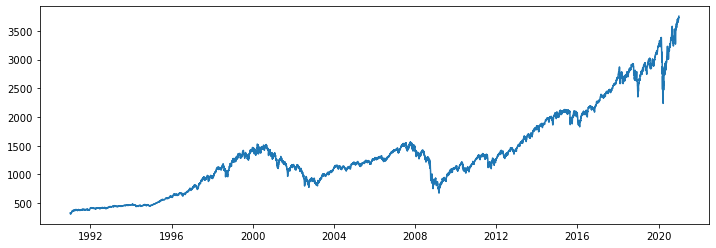

time: 1.84 s (started: 2022-08-22 22:40:22 +09:00)


In [5]:
fig, ax = plt.subplots(1, figsize=(12,4))
_ = ax.plot(df_snp.ds, df_snp.y)

## Determine Train data size

### Data set 1

In [12]:
train_end = '1999-12-31'
test_end = '2000-12-31'

df_train = df_snp[(df_snp.ds <= train_end)]
df_test = df_snp[(df_snp.ds > train_end) & (df_snp.ds <= test_end)]

time: 10 ms (started: 2022-08-17 22:14:19 +09:00)


In [13]:
df_train.ds.apply(lambda x: x.year).value_counts().sort_index()

1991    253
1992    254
1993    253
1994    252
1995    252
1996    254
1997    253
1998    252
1999    252
Name: ds, dtype: int64

time: 16.2 ms (started: 2022-08-17 22:14:21 +09:00)


In [14]:
BYEAR = df_train.ds.apply(lambda x: x.year).value_counts().mean()

time: 17.9 ms (started: 2022-08-17 22:14:24 +09:00)


In [15]:
#metric = 'rmse'
metric = 'mape'

time: 5.07 ms (started: 2022-08-17 22:14:25 +09:00)


#### cross-validation 1

In [16]:
hori = YEAR
peri = hori//4 # quarter
init = 3*YEAR

time: 4.62 ms (started: 2022-08-17 22:14:49 +09:00)


number of total forecasts

In [17]:
# init + hori + peri*N <= train_len
# N <= (train_len - init - hori)/peri
(len(df_train)*YEAR/BYEAR-init-hori) // peri

20.0

time: 9.56 ms (started: 2022-08-17 22:14:50 +09:00)


In [18]:
model = Prophet()
model.fit(df_train)
df_cv = cross_validation(model, initial=f'{init} days', period=f'{peri} days', horizon = f'{hori} days')

22:15:01 - cmdstanpy - INFO - Chain [1] start processing
22:15:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/21 [00:00<?, ?it/s]

22:15:06 - cmdstanpy - INFO - Chain [1] start processing
22:15:07 - cmdstanpy - INFO - Chain [1] done processing
22:15:13 - cmdstanpy - INFO - Chain [1] start processing
22:15:14 - cmdstanpy - INFO - Chain [1] done processing
22:15:22 - cmdstanpy - INFO - Chain [1] start processing
22:15:24 - cmdstanpy - INFO - Chain [1] done processing
22:15:32 - cmdstanpy - INFO - Chain [1] start processing
22:15:34 - cmdstanpy - INFO - Chain [1] done processing
22:15:39 - cmdstanpy - INFO - Chain [1] start processing
22:15:42 - cmdstanpy - INFO - Chain [1] done processing
22:15:47 - cmdstanpy - INFO - Chain [1] start processing
22:15:50 - cmdstanpy - INFO - Chain [1] done processing
22:15:56 - cmdstanpy - INFO - Chain [1] start processing
22:15:59 - cmdstanpy - INFO - Chain [1] done processing
22:16:04 - cmdstanpy - INFO - Chain [1] start processing
22:16:07 - cmdstanpy - INFO - Chain [1] done processing
22:16:12 - cmdstanpy - INFO - Chain [1] start processing
22:16:16 - cmdstanpy - INFO - Chain [1]

time: 3min 4s (started: 2022-08-17 22:15:00 +09:00)


In [19]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,36 days,1894.319485,43.523781,29.625681,0.035290,0.028432,0.035236,0.279134
1,39 days,1863.999337,43.174059,29.646555,0.035399,0.028773,0.035370,0.270440
2,40 days,1822.399105,42.689567,29.507277,0.035372,0.028874,0.035363,0.269542
3,41 days,1768.903027,42.058329,29.325397,0.035280,0.028773,0.035296,0.269542
4,42 days,1708.323807,41.331874,29.134605,0.035132,0.028962,0.035182,0.267655
...,...,...,...,...,...,...,...,...
231,361 days,7878.673693,88.761893,73.177984,0.092761,0.071928,0.098690,0.544025
232,362 days,7991.998426,89.397978,73.878862,0.093438,0.073692,0.099382,0.538846
233,363 days,8181.107248,90.449473,74.839228,0.094492,0.079083,0.100509,0.532255
234,364 days,8392.940854,91.612995,75.792765,0.095598,0.081899,0.101676,0.526415


time: 2.55 s (started: 2022-08-17 22:18:05 +09:00)


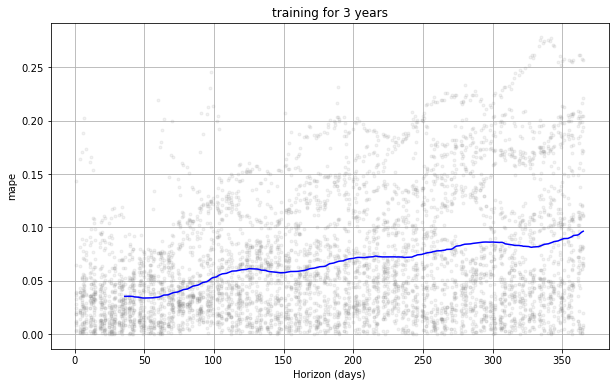

time: 834 ms (started: 2022-08-17 22:21:13 +09:00)


In [24]:
fig, ax = plt.subplots(figsize=(10,6))
_ = plot_cross_validation_metric(df_cv, metric=metric, ax=ax)
_ = ax.set_title(f'training for {round(init/YEAR)} years')

#### cross-validation 2

In [27]:
hori = YEAR
peri = hori//12 # monthly
init = 5*YEAR

time: 1.02 ms (started: 2022-08-17 22:22:18 +09:00)


number of total forecasts

In [28]:
(len(df_train)*YEAR/BYEAR-init-hori) // peri

36.0

time: 17 ms (started: 2022-08-17 22:22:20 +09:00)


In [29]:
model = Prophet()
model.fit(df_train)
df_cv = cross_validation(model, initial=f'{init} days', period=f'{peri} days', horizon = f'{hori} days')

22:22:38 - cmdstanpy - INFO - Chain [1] start processing
22:22:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/37 [00:00<?, ?it/s]

22:22:43 - cmdstanpy - INFO - Chain [1] start processing
22:22:48 - cmdstanpy - INFO - Chain [1] done processing
22:22:55 - cmdstanpy - INFO - Chain [1] start processing
22:22:59 - cmdstanpy - INFO - Chain [1] done processing
22:23:06 - cmdstanpy - INFO - Chain [1] start processing
22:23:10 - cmdstanpy - INFO - Chain [1] done processing
22:23:17 - cmdstanpy - INFO - Chain [1] start processing
22:23:21 - cmdstanpy - INFO - Chain [1] done processing
22:23:27 - cmdstanpy - INFO - Chain [1] start processing
22:23:30 - cmdstanpy - INFO - Chain [1] done processing
22:23:36 - cmdstanpy - INFO - Chain [1] start processing
22:23:39 - cmdstanpy - INFO - Chain [1] done processing
22:23:46 - cmdstanpy - INFO - Chain [1] start processing
22:23:49 - cmdstanpy - INFO - Chain [1] done processing
22:23:56 - cmdstanpy - INFO - Chain [1] start processing
22:23:59 - cmdstanpy - INFO - Chain [1] done processing
22:24:04 - cmdstanpy - INFO - Chain [1] start processing
22:24:09 - cmdstanpy - INFO - Chain [1]

time: 6min 20s (started: 2022-08-17 22:22:37 +09:00)


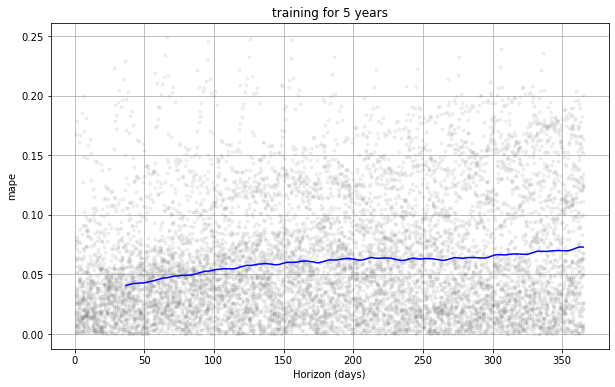

time: 1.06 s (started: 2022-08-17 22:28:58 +09:00)


In [30]:
fig, ax = plt.subplots(figsize=(10,6))
_ = plot_cross_validation_metric(df_cv, metric=metric, ax=ax)
_ = ax.set_title(f'training for {round(init/YEAR)} years')

22:29:54 - cmdstanpy - INFO - Chain [1] start processing
22:29:57 - cmdstanpy - INFO - Chain [1] done processing


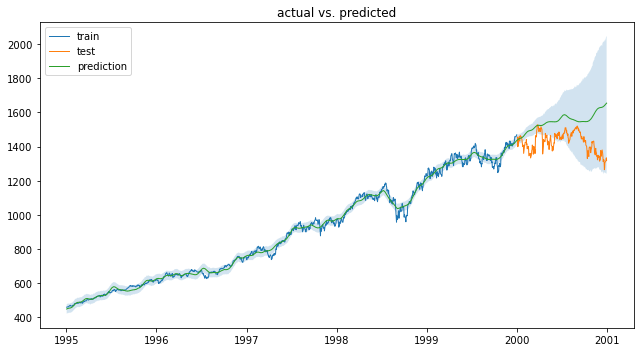

time: 10.3 s (started: 2022-08-17 22:29:54 +09:00)


In [32]:
start = df_train.ds.iloc[-1] - timedelta(days=init)
train = df_train.loc[df_train.ds >= start]
model = Prophet()
model.fit(train)

df_future = pd.concat([train.ds, df_test.ds]).to_frame()
df_pred = model.predict(df_future)

_ = plot_prediction(df_pred, df_test, train)

#### Tuning train period

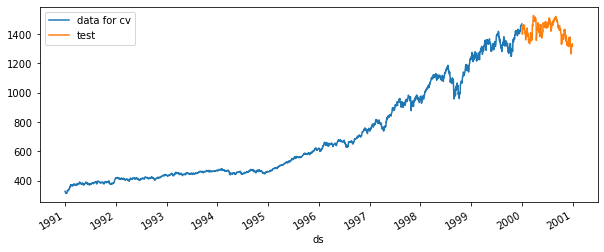

time: 784 ms (started: 2022-08-17 22:30:28 +09:00)


In [33]:
fig, ax = plt.subplots(figsize=(10,4))
df_train.set_index('ds').plot(ax=ax)
df_test.set_index('ds').plot(ax=ax)
_ = ax.legend(['data for cv', 'test'])

In [34]:
hori = YEAR
peri = hori//12 # monthly

time: 1.02 ms (started: 2022-08-17 22:30:45 +09:00)


In [38]:
# init + hori + peri*N <= train_len
# init <= train_len - hori - peri*N
train_year = df_train.ds.apply(lambda x: x.year).nunique()
N = 1
init_max = train_year*YEAR - hori - peri*N
init_max / YEAR

7.917808219178082

time: 22 ms (started: 2022-08-17 22:36:43 +09:00)


In [39]:
init_y_min, init_y_max = 3, 7

time: 869 µs (started: 2022-08-17 22:39:11 +09:00)


In [43]:
param_grid = {  
    'changepoint_prior_scale': [0.05], # default
    'seasonality_prior_scale': [10.], # default
    'initial': range(init_y_min, init_y_max+1, 1)    
}

time: 1 ms (started: 2022-08-17 22:43:31 +09:00)


In [44]:
#metric = 'rmse'
metric = 'mape'

time: 7.22 ms (started: 2022-08-17 22:43:32 +09:00)


In [45]:
# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
tuning_results = pd.DataFrame(all_params)
df_pm = pd.DataFrame()
   
# Use cross validation to evaluate all parameters
for params in all_params:
    
    init = params.pop('initial') * YEAR
    
    # believed the model fitted not with df_train but with init in cv
    m = Prophet(**params).fit(df_train) 
    
    df_cv = cross_validation(m, 
                             initial=f'{init} days', horizon=f'{hori} days', period=f'{peri} days', 
                             parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    
    # compare metric for max horizon
    p = df_p[metric].iloc[-1]
    if len(df_pm) > 0:
        if p < p_best:
            p_best = p
            df_cv_best = df_cv
        if p > p_worst:
            p_worst = p
            df_cv_worst = df_cv
    else:
        p_best = p_worst = p
        df_cv_best = df_cv_worst = df_cv
    
    df_pm = pd.concat([df_pm, df_p.iloc[-1:]], ignore_index=True)

# Find the best parameters
tuning_results = tuning_results.join(df_pm, how='left')

22:43:33 - cmdstanpy - INFO - Chain [1] start processing
22:43:38 - cmdstanpy - INFO - Chain [1] done processing
22:43:39 - cmdstanpy - INFO - Chain [1] start processing
22:43:39 - cmdstanpy - INFO - Chain [1] start processing
22:43:41 - cmdstanpy - INFO - Chain [1] done processing
22:43:41 - cmdstanpy - INFO - Chain [1] done processing
22:43:54 - cmdstanpy - INFO - Chain [1] start processing
22:43:55 - cmdstanpy - INFO - Chain [1] start processing
22:43:56 - cmdstanpy - INFO - Chain [1] done processing
22:43:56 - cmdstanpy - INFO - Chain [1] done processing
22:44:07 - cmdstanpy - INFO - Chain [1] start processing
22:44:08 - cmdstanpy - INFO - Chain [1] start processing
22:44:09 - cmdstanpy - INFO - Chain [1] done processing
22:44:10 - cmdstanpy - INFO - Chain [1] done processing
22:44:20 - cmdstanpy - INFO - Chain [1] start processing
22:44:21 - cmdstanpy - INFO - Chain [1] start processing
22:44:21 - cmdstanpy - INFO - Chain [1] done processing
22:44:24 - cmdstanpy - INFO - Chain [1]

time: 23min 32s (started: 2022-08-17 22:43:33 +09:00)


In [46]:
tuning_results

,changepoint_prior_scale,seasonality_prior_scale,initial,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,0.05,10.0,3,365 days,4817.175965,69.405878,53.162044,0.068167,0.051150,0.070819,0.396478
1,0.05,10.0,4,365 days,5238.736484,72.379116,56.128519,0.065538,0.050473,0.067599,0.394611
2,0.05,10.0,5,365 days,5642.374007,75.115737,57.865109,0.059599,0.046279,0.060601,0.376541
3,0.05,10.0,6,365 days,6231.774188,78.941587,62.591254,0.059603,0.046730,0.060194,0.363839
4,0.05,10.0,7,365 days,5162.468876,71.850323,53.976838,0.047389,0.033810,0.045962,0.418271


time: 41.8 ms (started: 2022-08-17 23:07:06 +09:00)


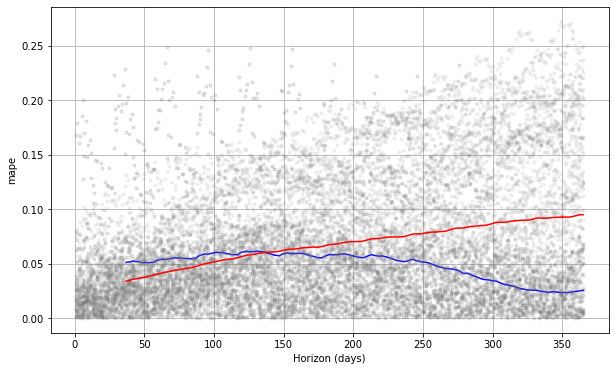

time: 1.43 s (started: 2022-08-17 23:17:42 +09:00)


In [47]:
#df_p = performance_metrics(df_cv_best)

fig, ax = plt.subplots(figsize=(10,6))
_ = plot_cross_validation_metric(df_cv_best, color='b', metric=metric, ax=ax)
_ = plot_cross_validation_metric(df_cv_worst, color='r', metric=metric, ax=ax)

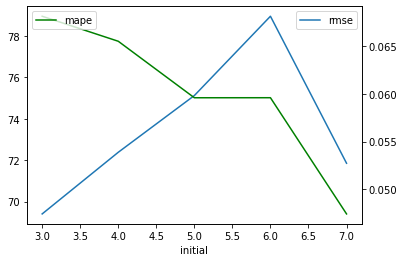

time: 767 ms (started: 2022-08-17 23:29:39 +09:00)


In [63]:
fig, ax = plt.subplots()
axt = ax.twinx()
_ = tuning_results[['initial', 'rmse']].set_index('initial').plot(ax=ax)
_ = tuning_results[['initial', 'mape']].set_index('initial').plot(ax=axt, c='green')
ax.legend(loc=1)
axt.legend(loc=2)

#### prediction with test data

23:42:14 - cmdstanpy - INFO - Chain [1] start processing
23:42:15 - cmdstanpy - INFO - Chain [1] done processing


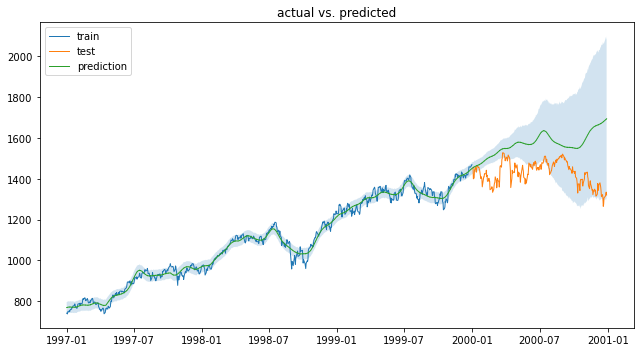

time: 10.6 s (started: 2022-08-17 23:42:14 +09:00)


In [73]:
init = 3
train = df_train.loc[df_train.ds >= df_train.ds.iloc[-1] - timedelta(days=init*YEAR)]
m = Prophet().fit(train)

df_future = pd.concat([train.ds, df_test.ds]).to_frame()
df_pred = m.predict(df_future)
_ = plot_prediction(df_pred, df_test, train)

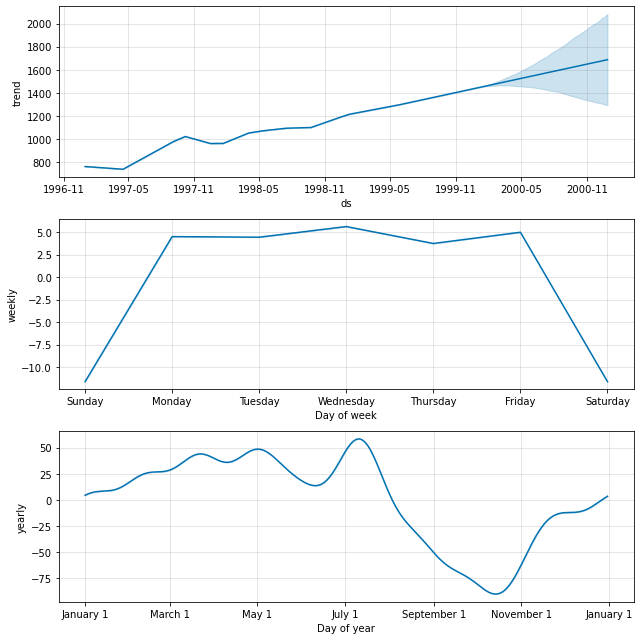

time: 1.98 s (started: 2022-08-17 23:42:28 +09:00)


In [74]:
m.plot_components(df_pred)

plt.tight_layout()
#plt.savefig('images/ch3_im4.png')
plt.show()

23:37:36 - cmdstanpy - INFO - Chain [1] start processing
23:37:39 - cmdstanpy - INFO - Chain [1] done processing


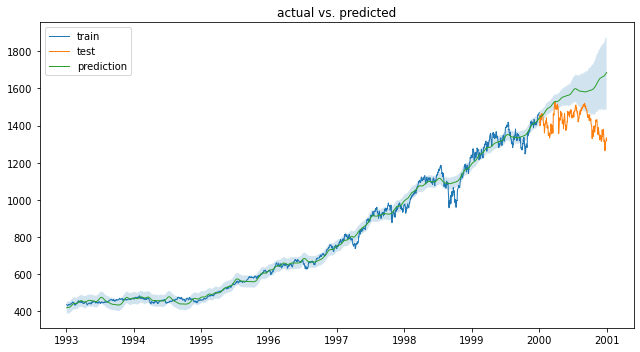

time: 11.6 s (started: 2022-08-17 23:37:36 +09:00)


In [71]:
init = 7
train = df_train.loc[df_train.ds >= df_train.ds.iloc[-1] - timedelta(days=init*YEAR)]
m = Prophet().fit(train)

df_future = pd.concat([train.ds, df_test.ds]).to_frame()
df_pred = m.predict(df_future)
_ = plot_prediction(df_pred, df_test, train)

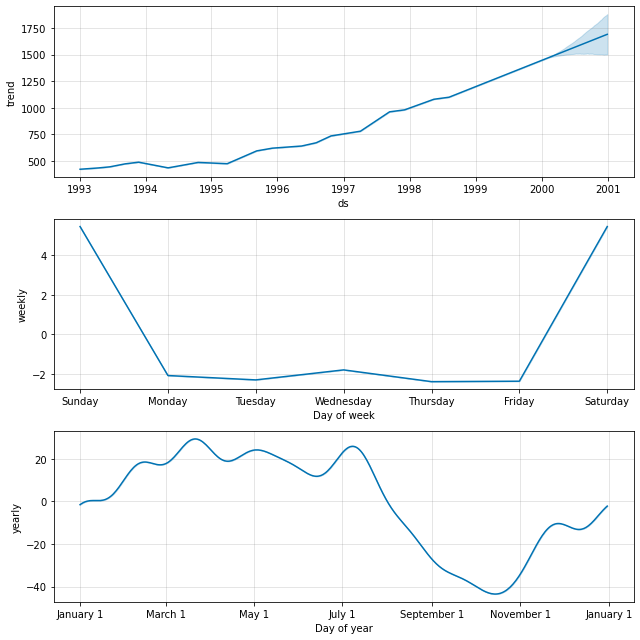

time: 1.73 s (started: 2022-08-17 23:38:29 +09:00)


In [72]:
m.plot_components(df_pred)

plt.tight_layout()
#plt.savefig('images/ch3_im4.png')
plt.show()

### Data set 2

In [28]:
train_end = '2009-12-31'
test_end = '2010-12-31'

df_train = df_snp[(df_snp.ds <= train_end)]
df_test = df_snp[(df_snp.ds > train_end) & (df_snp.ds <= test_end)]

time: 10.6 ms (started: 2022-08-18 13:28:10 +09:00)


In [29]:
df_train.ds.apply(lambda x: x.year).value_counts().sort_index()

1991    253
1992    254
1993    253
1994    252
1995    252
1996    254
1997    253
1998    252
1999    252
2000    252
2001    248
2002    252
2003    252
2004    252
2005    252
2006    251
2007    251
2008    253
2009    252
Name: ds, dtype: int64

time: 28 ms (started: 2022-08-18 13:28:11 +09:00)


In [30]:
BYEAR = df_train.ds.apply(lambda x: x.year).value_counts().mean()

time: 22.3 ms (started: 2022-08-18 13:28:11 +09:00)


In [31]:
#metric = 'rmse'
metric = 'mape'

time: 7.37 ms (started: 2022-08-18 13:28:12 +09:00)


#### Tuning train period

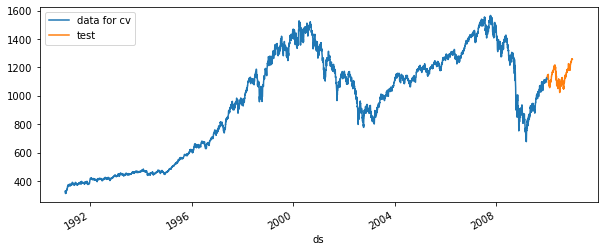

time: 571 ms (started: 2022-08-18 08:52:05 +09:00)


In [11]:
fig, ax = plt.subplots(figsize=(10,4))
df_train.set_index('ds').plot(ax=ax)
df_test.set_index('ds').plot(ax=ax)
_ = ax.legend(['data for cv', 'test'])

In [12]:
hori = YEAR
peri = hori//12 # monthly

time: 927 µs (started: 2022-08-18 08:52:17 +09:00)


In [13]:
# init + hori + peri*N <= train_len
# init <= train_len - hori - peri*N
train_year = df_train.ds.apply(lambda x: x.year).nunique()
N = 1
init_max = train_year*YEAR - hori - peri*N
init_max / YEAR

17.91780821917808

time: 25.4 ms (started: 2022-08-18 08:52:21 +09:00)


In [14]:
init_y_min, init_y_max = 8, 17

time: 885 µs (started: 2022-08-18 08:54:11 +09:00)


In [15]:
param_grid = {  
    'changepoint_prior_scale': [0.05], # default
    'seasonality_prior_scale': [10.], # default
    'initial': range(init_y_min, init_y_max+1, 1)    
}

time: 1.01 ms (started: 2022-08-18 08:54:12 +09:00)


In [16]:
#metric = 'rmse'
metric = 'mape'

time: 827 µs (started: 2022-08-18 08:54:34 +09:00)


In [17]:
# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
tuning_results = pd.DataFrame(all_params)
df_pm = pd.DataFrame()
   
# Use cross validation to evaluate all parameters
for params in all_params:
    
    init = params.pop('initial') * YEAR
    
    # believed the model fitted not with df_train but with init in cv
    m = Prophet(**params).fit(df_train) 
    
    df_cv = cross_validation(m, 
                             initial=f'{init} days', horizon=f'{hori} days', period=f'{peri} days', 
                             parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    
    # compare metric for max horizon
    p = df_p[metric].iloc[-1]
    if len(df_pm) > 0:
        if p < p_best:
            p_best = p
            df_cv_best = df_cv
        if p > p_worst:
            p_worst = p
            df_cv_worst = df_cv
    else:
        p_best = p_worst = p
        df_cv_best = df_cv_worst = df_cv
    
    df_pm = pd.concat([df_pm, df_p.iloc[-1:]], ignore_index=True)

# Find the best parameters
tuning_results = tuning_results.join(df_pm, how='left')

08:54:36 - cmdstanpy - INFO - Chain [1] start processing
08:54:43 - cmdstanpy - INFO - Chain [1] done processing
08:54:45 - cmdstanpy - INFO - Chain [1] start processing
08:54:45 - cmdstanpy - INFO - Chain [1] start processing
08:54:48 - cmdstanpy - INFO - Chain [1] done processing
08:54:50 - cmdstanpy - INFO - Chain [1] done processing
08:54:58 - cmdstanpy - INFO - Chain [1] start processing
08:55:00 - cmdstanpy - INFO - Chain [1] start processing
08:55:04 - cmdstanpy - INFO - Chain [1] done processing
08:55:04 - cmdstanpy - INFO - Chain [1] done processing
08:55:14 - cmdstanpy - INFO - Chain [1] start processing
08:55:15 - cmdstanpy - INFO - Chain [1] start processing
08:55:17 - cmdstanpy - INFO - Chain [1] done processing
08:55:18 - cmdstanpy - INFO - Chain [1] done processing
08:55:27 - cmdstanpy - INFO - Chain [1] start processing
08:55:28 - cmdstanpy - INFO - Chain [1] start processing
08:55:32 - cmdstanpy - INFO - Chain [1] done processing
08:55:32 - cmdstanpy - INFO - Chain [1]

time: 2h 1min 22s (started: 2022-08-18 08:54:35 +09:00)


In [18]:
tuning_results

,changepoint_prior_scale,seasonality_prior_scale,initial,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,0.05,10.0,8,365 days,67129.954881,259.094490,187.046874,0.174471,0.102012,0.162062,0.264842
1,0.05,10.0,9,365 days,73909.093721,271.862270,201.258405,0.189082,0.122057,0.175402,0.246127
2,0.05,10.0,10,365 days,71325.002813,267.067412,194.166465,0.186698,0.115433,0.174733,0.266653
3,0.05,10.0,11,365 days,73984.359737,272.000661,193.014007,0.186753,0.102125,0.175858,0.291445
4,0.05,10.0,12,365 days,82892.044087,287.909785,207.681441,0.199249,0.107457,0.185847,0.271609
5,0.05,10.0,13,365 days,75499.372048,274.771491,183.230077,0.178268,0.079436,0.149290,0.329772
6,0.05,10.0,14,365 days,86834.699547,294.677280,189.918479,0.189169,0.062967,0.150142,0.383592
7,0.05,10.0,15,365 days,114205.169369,337.942553,238.866556,0.240434,0.091790,0.188927,0.241079
8,0.05,10.0,16,365 days,166419.356830,407.945287,325.282493,0.335734,0.193148,0.259334,0.108340
9,0.05,10.0,17,365 days,287174.377689,535.886534,494.371711,0.543932,0.593312,0.406307,0.000000


time: 82.9 ms (started: 2022-08-18 10:55:57 +09:00)


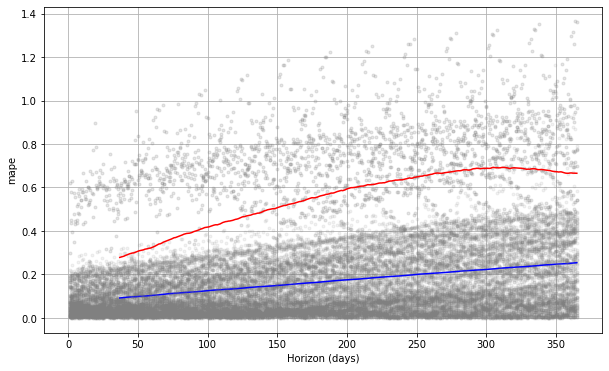

time: 2.03 s (started: 2022-08-18 10:59:38 +09:00)


In [19]:
#df_p = performance_metrics(df_cv_best)

fig, ax = plt.subplots(figsize=(10,6))
_ = plot_cross_validation_metric(df_cv_best, color='b', metric=metric, ax=ax)
_ = plot_cross_validation_metric(df_cv_worst, color='r', metric=metric, ax=ax)

#### prediction with test data

best init from mape

11:07:13 - cmdstanpy - INFO - Chain [1] start processing
11:07:15 - cmdstanpy - INFO - Chain [1] done processing


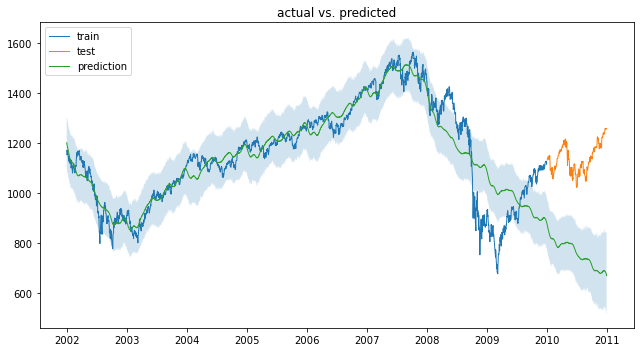

time: 10.4 s (started: 2022-08-18 11:07:13 +09:00)


In [20]:
init = 8
train = df_train.loc[df_train.ds >= df_train.ds.iloc[-1] - timedelta(days=init*YEAR)]
m = Prophet().fit(train)

df_future = pd.concat([train.ds, df_test.ds]).to_frame()
df_pred = m.predict(df_future)
_ = plot_prediction(df_pred, df_test, train)

worst init from mape

13:28:49 - cmdstanpy - INFO - Chain [1] start processing
13:28:56 - cmdstanpy - INFO - Chain [1] done processing


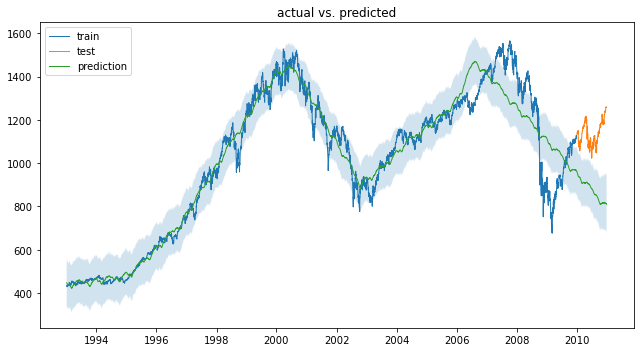

time: 16.7 s (started: 2022-08-18 13:28:48 +09:00)


In [33]:
init = 17
train = df_train.loc[df_train.ds >= df_train.ds.iloc[-1] - timedelta(days=init*YEAR)]
m = Prophet().fit(train)

df_future = pd.concat([train.ds, df_test.ds]).to_frame()
df_pred = m.predict(df_future)
_ = plot_prediction(df_pred, df_test, train)

best init of prv cv from mape

11:08:23 - cmdstanpy - INFO - Chain [1] start processing
11:08:25 - cmdstanpy - INFO - Chain [1] done processing


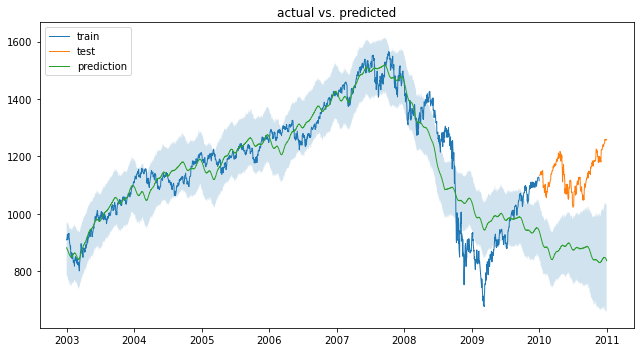

time: 12.5 s (started: 2022-08-18 11:08:23 +09:00)


In [21]:
init = 7
train = df_train.loc[df_train.ds >= df_train.ds.iloc[-1] - timedelta(days=init*YEAR)]
m = Prophet().fit(train)

df_future = pd.concat([train.ds, df_test.ds]).to_frame()
df_pred = m.predict(df_future)
_ = plot_prediction(df_pred, df_test, train)

best init of prv cv from rmse

11:09:37 - cmdstanpy - INFO - Chain [1] start processing
11:09:39 - cmdstanpy - INFO - Chain [1] done processing


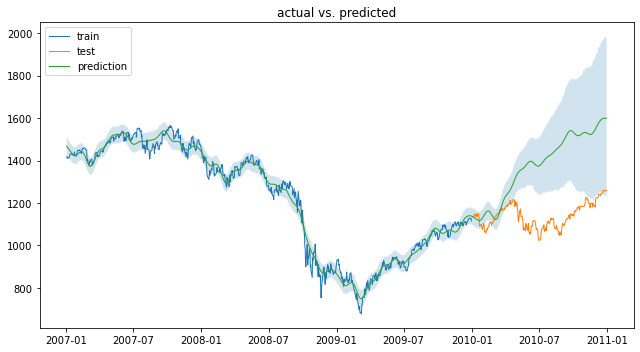

time: 8.4 s (started: 2022-08-18 11:09:37 +09:00)


In [22]:
init = 3
train = df_train.loc[df_train.ds >= df_train.ds.iloc[-1] - timedelta(days=init*YEAR)]
m = Prophet().fit(train)

df_future = pd.concat([train.ds, df_test.ds]).to_frame()
df_pred = m.predict(df_future)
_ = plot_prediction(df_pred, df_test, train)

## Cross-Validation Schemes

### Load Data

In [6]:
df_all = df_snp.copy()

time: 5.76 ms (started: 2022-08-22 22:40:41 +09:00)


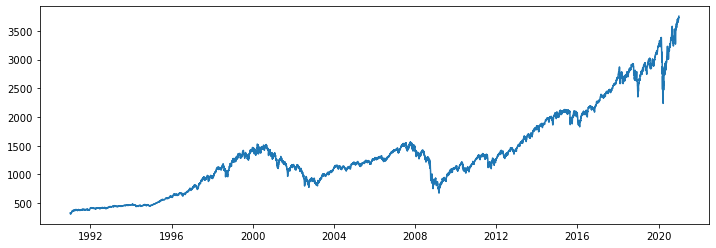

time: 584 ms (started: 2022-08-22 22:40:42 +09:00)


In [7]:
fig, ax = plt.subplots(1, figsize=(12,4))
_ = ax.plot(df_all.ds, df_all.y)

### 1. CV between Change points (Aborted)
- evaluate model for every train data span split by extrema
- aborted to do sheme 2

testing

15:09:11 - cmdstanpy - INFO - Chain [1] start processing
15:09:29 - cmdstanpy - INFO - Chain [1] done processing


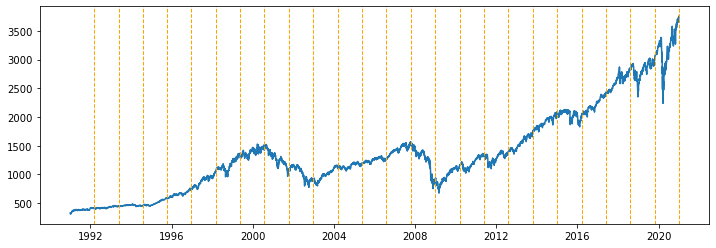

time: 19 s (started: 2022-08-18 15:09:11 +09:00)


In [94]:
#m = Prophet(n_changepoints=12, changepoint_range=1).fit(df_all)
m = Prophet(changepoint_range=1).fit(df_all)

fig, ax = plt.subplots(1, figsize=(12,4))
_ = ax.plot(df_all.ds, df_all.y)
#ax.vlines(m.changepoints, ymin=0, ymax=4000)
_ = [ax.axvline(x, lw=1, ls='--', c='orange') for x in m.changepoints]

split period

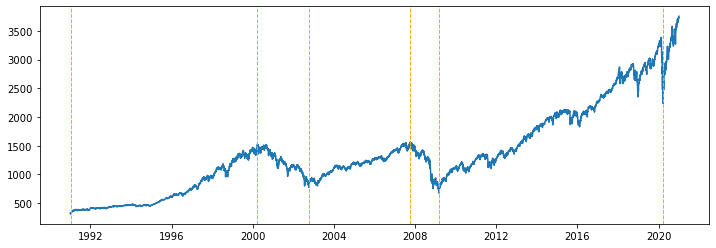

time: 723 ms (started: 2022-08-18 16:22:45 +09:00)


In [159]:
from scipy.signal import find_peaks, argrelmax, argrelmin

extrema = argrelmax(df_all.y.to_numpy(), order=300)
extrema = extrema[0]
e = argrelmin(df_all.y.to_numpy(), order=500)
extrema = np.concatenate((extrema, e[0]))
extrema = np.sort(extrema)

fig, ax = plt.subplots(1, figsize=(12,4))
_ = ax.plot(df_all.ds, df_all.y)
_ = [ax.axvline(df_all.ds.iloc[x], lw=1, ls='--', c='orange') for x in extrema]

In [160]:
grp = {i:g for g,i in enumerate(extrema)}
df_all['group'] = df_all.apply(lambda x: grp[x.name] if x.name in grp.keys() else None, axis=1).fillna(method='ffill').fillna(0)
df_all.groupby('group').ds.count()/252

group
0.0     9.253968
1.0     2.527778
2.0     4.992063
3.0     1.408730
4.0    11.027778
5.0     0.785714
Name: ds, dtype: float64

time: 200 ms (started: 2022-08-18 16:22:47 +09:00)


In [171]:
hori = YEAR
peri = hori//2 # testing
init = 3*YEAR

In [171]:
#for i in grp.keys():
for i in [2]:
    cols = ['ds','y']
    df_train = df_all.loc[df_all.group == i, cols]
    
    model = Prophet()
    model.fit(df_train)
    df_cv = cross_validation(model, initial=f'{init} days', period=f'{peri} days', horizon = f'{hori} days')

16:36:22 - cmdstanpy - INFO - Chain [1] start processing
16:36:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:36:24 - cmdstanpy - INFO - Chain [1] start processing
16:36:25 - cmdstanpy - INFO - Chain [1] done processing
16:36:31 - cmdstanpy - INFO - Chain [1] start processing
16:36:32 - cmdstanpy - INFO - Chain [1] done processing
16:36:38 - cmdstanpy - INFO - Chain [1] start processing
16:36:39 - cmdstanpy - INFO - Chain [1] done processing


time: 23 s (started: 2022-08-18 16:36:22 +09:00)


In [172]:
metric = 'mape'

time: 1.06 ms (started: 2022-08-18 16:36:45 +09:00)


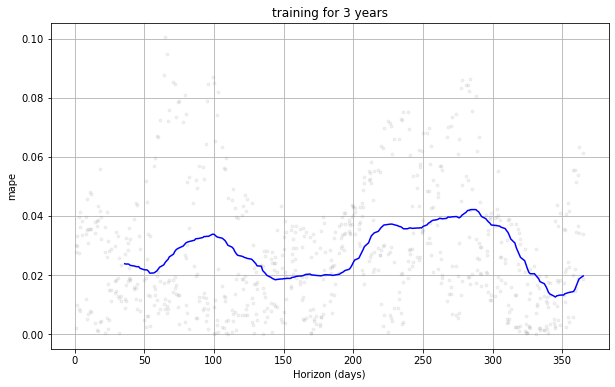

time: 747 ms (started: 2022-08-18 16:36:45 +09:00)


In [173]:
fig, ax = plt.subplots(figsize=(10,6))
_ = plot_cross_validation_metric(df_cv, metric=metric, ax=ax)
_ = ax.set_title(f'training for {round(init/YEAR)} years')

### 2. Plot Forecast Error for every training

In [8]:
hori = YEAR
peri = hori//2
#init = 3*YEAR
init = 5*YEAR

time: 1 ms (started: 2022-08-18 22:17:31 +09:00)


In [9]:
#df_train = df_all.loc[df_all.ds <= '1995-12-31'] # testing
#df_train = df_all.loc[df_all.ds <= '2000-12-31'] # testing
df_train = df_all

time: 768 µs (started: 2022-08-18 22:17:33 +09:00)


In [10]:
model = Prophet()
model.fit(df_train)
df_cv = cross_validation(model, initial=f'{init} days', period=f'{peri} days', horizon = f'{hori} days')

22:17:36 - cmdstanpy - INFO - Chain [1] start processing
22:18:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/49 [00:00<?, ?it/s]

22:18:03 - cmdstanpy - INFO - Chain [1] start processing
22:18:07 - cmdstanpy - INFO - Chain [1] done processing
22:18:12 - cmdstanpy - INFO - Chain [1] start processing
22:18:15 - cmdstanpy - INFO - Chain [1] done processing
22:18:21 - cmdstanpy - INFO - Chain [1] start processing
22:18:25 - cmdstanpy - INFO - Chain [1] done processing
22:18:30 - cmdstanpy - INFO - Chain [1] start processing
22:18:33 - cmdstanpy - INFO - Chain [1] done processing
22:18:38 - cmdstanpy - INFO - Chain [1] start processing
22:18:43 - cmdstanpy - INFO - Chain [1] done processing
22:18:48 - cmdstanpy - INFO - Chain [1] start processing
22:18:51 - cmdstanpy - INFO - Chain [1] done processing
22:19:01 - cmdstanpy - INFO - Chain [1] start processing
22:19:03 - cmdstanpy - INFO - Chain [1] done processing
22:19:08 - cmdstanpy - INFO - Chain [1] start processing
22:19:13 - cmdstanpy - INFO - Chain [1] done processing
22:19:18 - cmdstanpy - INFO - Chain [1] start processing
22:19:21 - cmdstanpy - INFO - Chain [1]

time: 14min 1s (started: 2022-08-18 22:17:35 +09:00)


In [11]:
df_pm = pd.DataFrame()
for i in df_cv.cutoff.unique():
    df_p = performance_metrics(df_cv.loc[df_cv.cutoff==i])
    df_p_l = df_p.iloc[-1:].assign(cutoff=i)
    df_pm = pd.concat([df_pm, df_p_l], ignore_index=True)

time: 1min 53s (started: 2022-08-18 22:31:37 +09:00)


In [12]:
df_pm.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage,cutoff
0,365 days,460.322629,21.455131,18.856223,0.024934,0.025411,0.024535,1.0,1996-01-31
1,365 days,20869.417307,144.462512,143.377277,0.155417,0.154861,0.168675,0.0,1996-07-31
2,365 days,6097.969715,78.089498,76.993500,0.080059,0.079097,0.083486,1.0,1997-01-29
3,365 days,10494.424193,102.442297,100.938750,0.087232,0.089473,0.091319,0.0,1997-07-30
4,365 days,494.034611,22.226889,17.418831,0.013912,0.010166,0.014057,1.0,1998-01-28


time: 37.1 ms (started: 2022-08-18 22:33:30 +09:00)


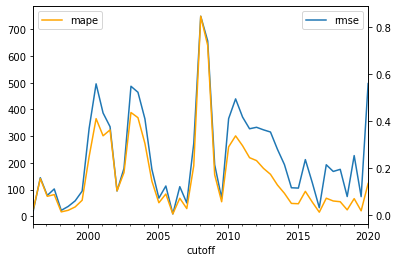

time: 816 ms (started: 2022-08-18 22:33:31 +09:00)


In [13]:
fig, ax = plt.subplots()
axt = ax.twinx()
df_pm.set_index('cutoff').loc[:, 'rmse'].plot(ax=ax)
df_pm.set_index('cutoff').loc[:, 'mape'].plot(ax=axt,  c='orange')
ax.legend(loc=1)
_ = axt.legend(loc=2)

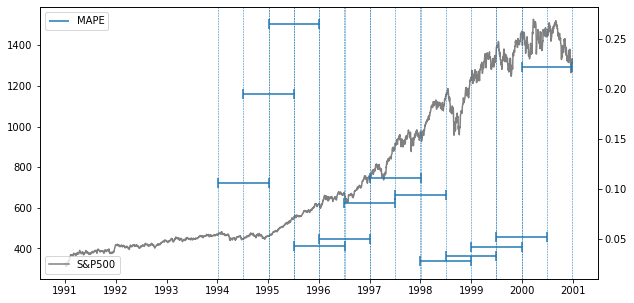

time: 960 ms (started: 2022-08-18 18:58:34 +09:00)


In [291]:
# result of data to 2000, 3 year init
#plot_cv_metric(df_train, df_pm)

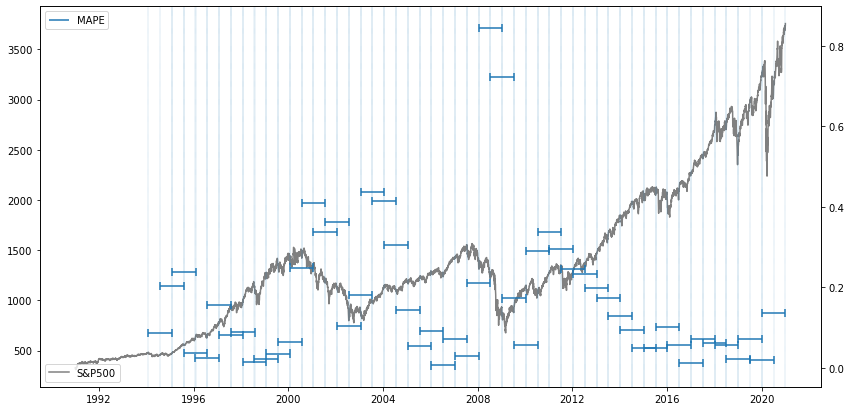

time: 1.37 s (started: 2022-08-18 19:41:55 +09:00)


In [302]:
# result of data to 2020, 3 year init
#plot_cv_metric(df_train, df_pm)

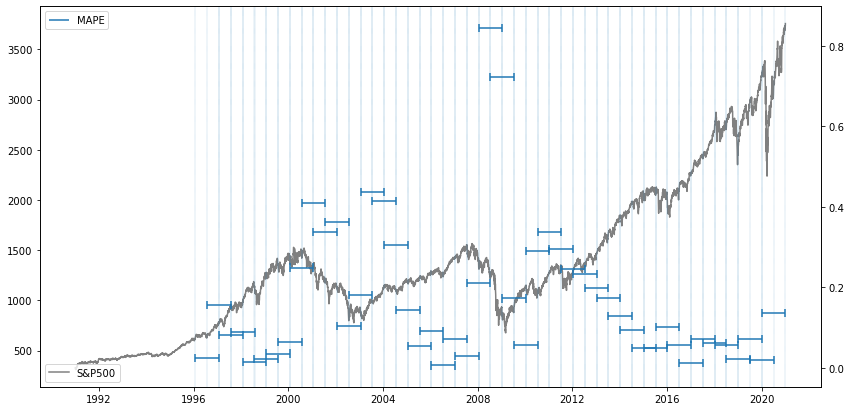

time: 1.32 s (started: 2022-08-18 22:33:31 +09:00)


In [14]:
# result of data to 2020, 5 year init
plot_cv_metric(df_train, df_pm)

### 3. Forecast vs Trend (based on scheme 2)

In [8]:
hori = YEAR
peri = hori//2
#init = 3*YEAR
init = 5*YEAR

time: 1e+03 µs (started: 2022-08-20 11:32:09 +09:00)


In [9]:
#df_train = df_all.loc[df_all.ds <= '1997-12-31'] # testing
#df_train = df_all.loc[df_all.ds <= '2000-12-31'] # testing
df_train = df_all

time: 779 µs (started: 2022-08-20 11:32:10 +09:00)


In [10]:
model = Prophet()
model.fit(df_train)
df_cv = cross_validation(model, initial=f'{init} days', period=f'{peri} days', horizon = f'{hori} days')

11:32:11 - cmdstanpy - INFO - Chain [1] start processing
11:32:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/49 [00:00<?, ?it/s]

11:32:38 - cmdstanpy - INFO - Chain [1] start processing
11:32:41 - cmdstanpy - INFO - Chain [1] done processing
11:32:48 - cmdstanpy - INFO - Chain [1] start processing
11:32:51 - cmdstanpy - INFO - Chain [1] done processing
11:32:58 - cmdstanpy - INFO - Chain [1] start processing
11:33:02 - cmdstanpy - INFO - Chain [1] done processing
11:33:08 - cmdstanpy - INFO - Chain [1] start processing
11:33:11 - cmdstanpy - INFO - Chain [1] done processing
11:33:16 - cmdstanpy - INFO - Chain [1] start processing
11:33:21 - cmdstanpy - INFO - Chain [1] done processing
11:33:26 - cmdstanpy - INFO - Chain [1] start processing
11:33:29 - cmdstanpy - INFO - Chain [1] done processing
11:33:34 - cmdstanpy - INFO - Chain [1] start processing
11:33:37 - cmdstanpy - INFO - Chain [1] done processing
11:33:42 - cmdstanpy - INFO - Chain [1] start processing
11:33:47 - cmdstanpy - INFO - Chain [1] done processing
11:33:52 - cmdstanpy - INFO - Chain [1] start processing
11:33:56 - cmdstanpy - INFO - Chain [1]

time: 14min 13s (started: 2022-08-20 11:32:11 +09:00)


In [11]:
df_pm = pd.DataFrame()
N = df_cv.cutoff.nunique()
for n, i in enumerate(df_cv.cutoff.unique()):
    ### performace for every cutoff
    df_p = performance_metrics(df_cv.loc[df_cv.cutoff==i])
    # take metric for full test range (one year)
    df_p_l = df_p.iloc[-1:].assign(cutoff=i)
    
    ### trend for each cutoff
    s = df_p_l.iloc[0]
    train = df_train.loc[(df_train.ds < s.cutoff) & (df_train.ds >= s.cutoff - timedelta(days=init))]
    test = df_train.loc[(df_train.ds >= s.cutoff) & (df_train.ds < s.cutoff + s.horizon)]
    m = Prophet().fit(train)
    df_future = pd.concat([train.ds, test.ds]).to_frame()
    df_pred = m.predict(df_future)
    
    y = df_pred.trend
    x = df_pred.ds
    X = sm.add_constant(x.apply(pd.Timestamp.to_julian_date))
    res = sm.OLS(y, X).fit()
    
    df_p_l['trend rsquared'] = res.rsquared
    df_p_l['trend aic'] = res.aic
    #plot_ols_fit(res, x, y)
    
    df_pm = pd.concat([df_pm, df_p_l], ignore_index=True)
    print(f'{(n+1)/N*100:.0f}% finished.')

11:46:26 - cmdstanpy - INFO - Chain [1] start processing
11:46:29 - cmdstanpy - INFO - Chain [1] done processing


2% finished.


11:46:39 - cmdstanpy - INFO - Chain [1] start processing
11:46:41 - cmdstanpy - INFO - Chain [1] done processing


4% finished.


11:46:51 - cmdstanpy - INFO - Chain [1] start processing
11:46:54 - cmdstanpy - INFO - Chain [1] done processing


6% finished.


11:47:03 - cmdstanpy - INFO - Chain [1] start processing
11:47:06 - cmdstanpy - INFO - Chain [1] done processing


8% finished.


11:47:16 - cmdstanpy - INFO - Chain [1] start processing
11:47:20 - cmdstanpy - INFO - Chain [1] done processing


10% finished.


11:47:29 - cmdstanpy - INFO - Chain [1] start processing
11:47:32 - cmdstanpy - INFO - Chain [1] done processing


12% finished.


11:47:41 - cmdstanpy - INFO - Chain [1] start processing
11:47:43 - cmdstanpy - INFO - Chain [1] done processing


14% finished.


11:47:52 - cmdstanpy - INFO - Chain [1] start processing
11:47:54 - cmdstanpy - INFO - Chain [1] done processing


16% finished.


11:48:04 - cmdstanpy - INFO - Chain [1] start processing
11:48:06 - cmdstanpy - INFO - Chain [1] done processing


18% finished.


11:48:15 - cmdstanpy - INFO - Chain [1] start processing
11:48:17 - cmdstanpy - INFO - Chain [1] done processing


20% finished.


11:48:26 - cmdstanpy - INFO - Chain [1] start processing
11:48:29 - cmdstanpy - INFO - Chain [1] done processing


22% finished.


11:48:38 - cmdstanpy - INFO - Chain [1] start processing
11:48:41 - cmdstanpy - INFO - Chain [1] done processing


24% finished.


11:48:50 - cmdstanpy - INFO - Chain [1] start processing
11:48:52 - cmdstanpy - INFO - Chain [1] done processing


27% finished.


11:49:01 - cmdstanpy - INFO - Chain [1] start processing
11:49:03 - cmdstanpy - INFO - Chain [1] done processing


29% finished.


11:49:13 - cmdstanpy - INFO - Chain [1] start processing
11:49:14 - cmdstanpy - INFO - Chain [1] done processing


31% finished.


11:49:24 - cmdstanpy - INFO - Chain [1] start processing
11:49:26 - cmdstanpy - INFO - Chain [1] done processing


33% finished.


11:49:35 - cmdstanpy - INFO - Chain [1] start processing
11:49:37 - cmdstanpy - INFO - Chain [1] done processing


35% finished.


11:49:46 - cmdstanpy - INFO - Chain [1] start processing
11:49:48 - cmdstanpy - INFO - Chain [1] done processing


37% finished.


11:49:58 - cmdstanpy - INFO - Chain [1] start processing
11:49:59 - cmdstanpy - INFO - Chain [1] done processing


39% finished.


11:50:09 - cmdstanpy - INFO - Chain [1] start processing
11:50:10 - cmdstanpy - INFO - Chain [1] done processing


41% finished.


11:50:20 - cmdstanpy - INFO - Chain [1] start processing
11:50:22 - cmdstanpy - INFO - Chain [1] done processing


43% finished.


11:50:32 - cmdstanpy - INFO - Chain [1] start processing
11:50:34 - cmdstanpy - INFO - Chain [1] done processing


45% finished.


11:50:44 - cmdstanpy - INFO - Chain [1] start processing
11:50:46 - cmdstanpy - INFO - Chain [1] done processing


47% finished.


11:50:55 - cmdstanpy - INFO - Chain [1] start processing
11:50:58 - cmdstanpy - INFO - Chain [1] done processing


49% finished.


11:51:07 - cmdstanpy - INFO - Chain [1] start processing
11:51:09 - cmdstanpy - INFO - Chain [1] done processing


51% finished.


11:51:19 - cmdstanpy - INFO - Chain [1] start processing
11:51:21 - cmdstanpy - INFO - Chain [1] done processing


53% finished.


11:51:31 - cmdstanpy - INFO - Chain [1] start processing
11:51:33 - cmdstanpy - INFO - Chain [1] done processing


55% finished.


11:51:42 - cmdstanpy - INFO - Chain [1] start processing
11:51:45 - cmdstanpy - INFO - Chain [1] done processing


57% finished.


11:51:55 - cmdstanpy - INFO - Chain [1] start processing
11:51:56 - cmdstanpy - INFO - Chain [1] done processing


59% finished.


11:52:06 - cmdstanpy - INFO - Chain [1] start processing
11:52:08 - cmdstanpy - INFO - Chain [1] done processing


61% finished.


11:52:17 - cmdstanpy - INFO - Chain [1] start processing
11:52:20 - cmdstanpy - INFO - Chain [1] done processing


63% finished.


11:52:29 - cmdstanpy - INFO - Chain [1] start processing
11:52:31 - cmdstanpy - INFO - Chain [1] done processing


65% finished.


11:52:41 - cmdstanpy - INFO - Chain [1] start processing
11:52:43 - cmdstanpy - INFO - Chain [1] done processing


67% finished.


11:52:52 - cmdstanpy - INFO - Chain [1] start processing
11:52:54 - cmdstanpy - INFO - Chain [1] done processing


69% finished.


11:53:03 - cmdstanpy - INFO - Chain [1] start processing
11:53:05 - cmdstanpy - INFO - Chain [1] done processing


71% finished.


11:53:15 - cmdstanpy - INFO - Chain [1] start processing
11:53:18 - cmdstanpy - INFO - Chain [1] done processing


73% finished.


11:53:27 - cmdstanpy - INFO - Chain [1] start processing
11:53:30 - cmdstanpy - INFO - Chain [1] done processing


76% finished.


11:53:39 - cmdstanpy - INFO - Chain [1] start processing
11:53:41 - cmdstanpy - INFO - Chain [1] done processing


78% finished.


11:53:51 - cmdstanpy - INFO - Chain [1] start processing
11:53:53 - cmdstanpy - INFO - Chain [1] done processing


80% finished.


11:54:02 - cmdstanpy - INFO - Chain [1] start processing
11:54:05 - cmdstanpy - INFO - Chain [1] done processing


82% finished.


11:54:14 - cmdstanpy - INFO - Chain [1] start processing
11:54:16 - cmdstanpy - INFO - Chain [1] done processing


84% finished.


11:54:25 - cmdstanpy - INFO - Chain [1] start processing
11:54:27 - cmdstanpy - INFO - Chain [1] done processing


86% finished.


11:54:36 - cmdstanpy - INFO - Chain [1] start processing
11:54:37 - cmdstanpy - INFO - Chain [1] done processing


88% finished.


11:54:47 - cmdstanpy - INFO - Chain [1] start processing
11:54:49 - cmdstanpy - INFO - Chain [1] done processing


90% finished.


11:54:58 - cmdstanpy - INFO - Chain [1] start processing
11:55:02 - cmdstanpy - INFO - Chain [1] done processing


92% finished.


11:55:11 - cmdstanpy - INFO - Chain [1] start processing
11:55:14 - cmdstanpy - INFO - Chain [1] done processing


94% finished.


11:55:24 - cmdstanpy - INFO - Chain [1] start processing
11:55:26 - cmdstanpy - INFO - Chain [1] done processing


96% finished.


11:55:36 - cmdstanpy - INFO - Chain [1] start processing
11:55:38 - cmdstanpy - INFO - Chain [1] done processing


98% finished.


11:55:48 - cmdstanpy - INFO - Chain [1] start processing
11:55:51 - cmdstanpy - INFO - Chain [1] done processing


100% finished.
time: 9min 33s (started: 2022-08-20 11:46:24 +09:00)


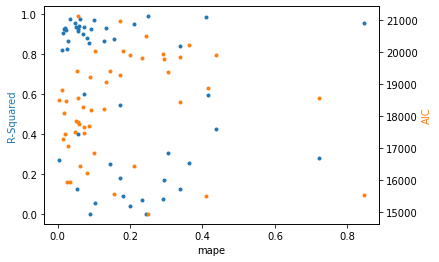

time: 603 ms (started: 2022-08-20 12:51:42 +09:00)


In [40]:
metric = 'mape'

fig, ax = plt.subplots()

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
c1, c2 = colors[0], colors[1]

ax.scatter(df_pm[metric], df_pm['trend rsquared'], c=c1, label='R-Squared', marker='.')
axt = ax.twinx()
axt.scatter(df_pm[metric], df_pm['trend aic'], c=c2, label='AIC', marker='.')
#ax.legend(loc=1)
#axt.legend(loc=4)
ax.set_xlabel(metric)
ax.set_ylabel('R-Squared')
axt.set_ylabel('AIC')
axt.yaxis.label.set_color(c2)
ax.yaxis.label.set_color(c1)
plt.show()

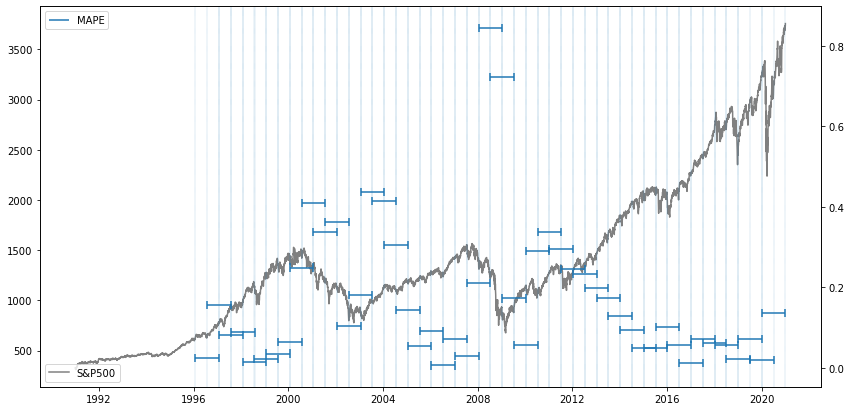

time: 1.32 s (started: 2022-08-18 22:33:31 +09:00)


In [14]:
# result of data to 2020, 5 year init
plot_cv_metric(df_train, df_pm)

### 4. Scheme 3 with Log Returns

In [6]:
df_logret = df_snp.copy()
df_logret['y'] = df_logret['y'].apply(lambda x: np.log(x)).diff()
df_logret = df_logret.dropna(subset='y')
df_logret

,ds,y
1,1991-01-03,-0.013883
2,1991-01-04,-0.002800
3,1991-01-07,-0.017599
4,1991-01-08,-0.001587
5,1991-01-09,-0.010856
...,...,...
7554,2020-12-24,0.003530
7555,2020-12-28,0.008685
7556,2020-12-29,-0.002230
7557,2020-12-30,0.001341


time: 91.4 ms (started: 2022-08-22 11:32:01 +09:00)


data seems to make fit not with prophet but with GARCH

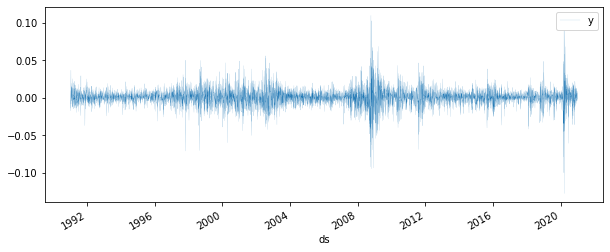

time: 696 ms (started: 2022-08-22 11:34:37 +09:00)


In [11]:
fig, ax = plt.subplots(figsize=(10,4))
_ = df_logret.set_index('ds').plot(ax=ax, lw=0.1)

In [12]:
hori = YEAR
peri = hori//2
init = 5*YEAR

time: 1.08 ms (started: 2022-08-22 11:34:51 +09:00)


In [24]:
#df_train = df_logret.loc[df_logret.ds <= '1997-12-31'] # testing
df_train = df_logret

time: 874 µs (started: 2022-08-22 11:50:42 +09:00)


In [25]:
model = Prophet()
model.fit(df_train)
df_cv = cross_validation(model, initial=f'{init} days', period=f'{peri} days', horizon = f'{hori} days')

11:50:45 - cmdstanpy - INFO - Chain [1] start processing
11:50:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/49 [00:00<?, ?it/s]

11:50:48 - cmdstanpy - INFO - Chain [1] start processing
11:50:49 - cmdstanpy - INFO - Chain [1] done processing
11:50:55 - cmdstanpy - INFO - Chain [1] start processing
11:50:56 - cmdstanpy - INFO - Chain [1] done processing
11:51:03 - cmdstanpy - INFO - Chain [1] start processing
11:51:04 - cmdstanpy - INFO - Chain [1] done processing
11:51:11 - cmdstanpy - INFO - Chain [1] start processing
11:51:12 - cmdstanpy - INFO - Chain [1] done processing
11:51:18 - cmdstanpy - INFO - Chain [1] start processing
11:51:19 - cmdstanpy - INFO - Chain [1] done processing
11:51:24 - cmdstanpy - INFO - Chain [1] start processing
11:51:25 - cmdstanpy - INFO - Chain [1] done processing
11:51:30 - cmdstanpy - INFO - Chain [1] start processing
11:51:31 - cmdstanpy - INFO - Chain [1] done processing
11:51:36 - cmdstanpy - INFO - Chain [1] start processing
11:51:37 - cmdstanpy - INFO - Chain [1] done processing
11:51:43 - cmdstanpy - INFO - Chain [1] start processing
11:51:43 - cmdstanpy - INFO - Chain [1]

time: 5min 46s (started: 2022-08-22 11:50:44 +09:00)


In [26]:
df_pm = pd.DataFrame()
N = df_cv.cutoff.nunique()
for n, i in enumerate(df_cv.cutoff.unique()):
    ### performace for every cutoff
    df_p = performance_metrics(df_cv.loc[df_cv.cutoff==i])
    # take metric for full test range (one year)
    df_p_l = df_p.iloc[-1:].assign(cutoff=i)
    
    ### trend for each cutoff
    s = df_p_l.iloc[0]
    train = df_train.loc[(df_train.ds < s.cutoff) & (df_train.ds >= s.cutoff - timedelta(days=init))]
    test = df_train.loc[(df_train.ds >= s.cutoff) & (df_train.ds < s.cutoff + s.horizon)]
    m = Prophet().fit(train)
    df_future = pd.concat([train.ds, test.ds]).to_frame()
    df_pred = m.predict(df_future)
    
    y = df_pred.trend
    x = df_pred.ds
    X = sm.add_constant(x.apply(pd.Timestamp.to_julian_date))
    res = sm.OLS(y, X).fit()
    
    df_p_l['trend rsquared'] = res.rsquared
    df_p_l['trend aic'] = res.aic
    #plot_ols_fit(res, x, y)
    
    df_pm = pd.concat([df_pm, df_p_l], ignore_index=True)
    print(f'{(n+1)/N*100:.0f}% finished.')

11:56:33 - cmdstanpy - INFO - Chain [1] start processing
11:56:33 - cmdstanpy - INFO - Chain [1] done processing


2% finished.


11:56:42 - cmdstanpy - INFO - Chain [1] start processing
11:56:42 - cmdstanpy - INFO - Chain [1] done processing


4% finished.


11:56:52 - cmdstanpy - INFO - Chain [1] start processing
11:56:52 - cmdstanpy - INFO - Chain [1] done processing


6% finished.


11:57:01 - cmdstanpy - INFO - Chain [1] start processing
11:57:01 - cmdstanpy - INFO - Chain [1] done processing


8% finished.


11:57:10 - cmdstanpy - INFO - Chain [1] start processing
11:57:10 - cmdstanpy - INFO - Chain [1] done processing


10% finished.


11:57:20 - cmdstanpy - INFO - Chain [1] start processing
11:57:20 - cmdstanpy - INFO - Chain [1] done processing


12% finished.


11:57:29 - cmdstanpy - INFO - Chain [1] start processing
11:57:29 - cmdstanpy - INFO - Chain [1] done processing


14% finished.


11:57:39 - cmdstanpy - INFO - Chain [1] start processing
11:57:39 - cmdstanpy - INFO - Chain [1] done processing


16% finished.


11:57:49 - cmdstanpy - INFO - Chain [1] start processing
11:57:49 - cmdstanpy - INFO - Chain [1] done processing


18% finished.


11:57:59 - cmdstanpy - INFO - Chain [1] start processing
11:57:59 - cmdstanpy - INFO - Chain [1] done processing


20% finished.


11:58:08 - cmdstanpy - INFO - Chain [1] start processing
11:58:08 - cmdstanpy - INFO - Chain [1] done processing


22% finished.


11:58:18 - cmdstanpy - INFO - Chain [1] start processing
11:58:18 - cmdstanpy - INFO - Chain [1] done processing


24% finished.


11:58:27 - cmdstanpy - INFO - Chain [1] start processing
11:58:27 - cmdstanpy - INFO - Chain [1] done processing


27% finished.


11:58:36 - cmdstanpy - INFO - Chain [1] start processing
11:58:37 - cmdstanpy - INFO - Chain [1] done processing


29% finished.


11:58:47 - cmdstanpy - INFO - Chain [1] start processing
11:58:47 - cmdstanpy - INFO - Chain [1] done processing


31% finished.


11:58:56 - cmdstanpy - INFO - Chain [1] start processing
11:58:56 - cmdstanpy - INFO - Chain [1] done processing


33% finished.


11:59:05 - cmdstanpy - INFO - Chain [1] start processing
11:59:06 - cmdstanpy - INFO - Chain [1] done processing


35% finished.


11:59:15 - cmdstanpy - INFO - Chain [1] start processing
11:59:15 - cmdstanpy - INFO - Chain [1] done processing


37% finished.


11:59:24 - cmdstanpy - INFO - Chain [1] start processing
11:59:24 - cmdstanpy - INFO - Chain [1] done processing


39% finished.


11:59:33 - cmdstanpy - INFO - Chain [1] start processing
11:59:34 - cmdstanpy - INFO - Chain [1] done processing


41% finished.


11:59:43 - cmdstanpy - INFO - Chain [1] start processing
11:59:43 - cmdstanpy - INFO - Chain [1] done processing


43% finished.


11:59:52 - cmdstanpy - INFO - Chain [1] start processing
11:59:53 - cmdstanpy - INFO - Chain [1] done processing


45% finished.


12:00:02 - cmdstanpy - INFO - Chain [1] start processing
12:00:02 - cmdstanpy - INFO - Chain [1] done processing


47% finished.


12:00:11 - cmdstanpy - INFO - Chain [1] start processing
12:00:12 - cmdstanpy - INFO - Chain [1] done processing


49% finished.


12:00:21 - cmdstanpy - INFO - Chain [1] start processing
12:00:21 - cmdstanpy - INFO - Chain [1] done processing


51% finished.


12:00:30 - cmdstanpy - INFO - Chain [1] start processing
12:00:30 - cmdstanpy - INFO - Chain [1] done processing


53% finished.


12:00:40 - cmdstanpy - INFO - Chain [1] start processing
12:00:40 - cmdstanpy - INFO - Chain [1] done processing


55% finished.


12:00:49 - cmdstanpy - INFO - Chain [1] start processing
12:00:49 - cmdstanpy - INFO - Chain [1] done processing


57% finished.


12:00:58 - cmdstanpy - INFO - Chain [1] start processing
12:00:58 - cmdstanpy - INFO - Chain [1] done processing


59% finished.


12:01:08 - cmdstanpy - INFO - Chain [1] start processing
12:01:08 - cmdstanpy - INFO - Chain [1] done processing


61% finished.


12:01:17 - cmdstanpy - INFO - Chain [1] start processing
12:01:17 - cmdstanpy - INFO - Chain [1] done processing


63% finished.


12:01:26 - cmdstanpy - INFO - Chain [1] start processing
12:01:26 - cmdstanpy - INFO - Chain [1] done processing


65% finished.


12:01:36 - cmdstanpy - INFO - Chain [1] start processing
12:01:36 - cmdstanpy - INFO - Chain [1] done processing


67% finished.


12:01:46 - cmdstanpy - INFO - Chain [1] start processing
12:01:46 - cmdstanpy - INFO - Chain [1] done processing


69% finished.


12:01:55 - cmdstanpy - INFO - Chain [1] start processing
12:01:56 - cmdstanpy - INFO - Chain [1] done processing


71% finished.


12:02:05 - cmdstanpy - INFO - Chain [1] start processing
12:02:05 - cmdstanpy - INFO - Chain [1] done processing


73% finished.


12:02:14 - cmdstanpy - INFO - Chain [1] start processing
12:02:15 - cmdstanpy - INFO - Chain [1] done processing


76% finished.


12:02:24 - cmdstanpy - INFO - Chain [1] start processing
12:02:24 - cmdstanpy - INFO - Chain [1] done processing


78% finished.


12:02:33 - cmdstanpy - INFO - Chain [1] start processing
12:02:33 - cmdstanpy - INFO - Chain [1] done processing


80% finished.


12:02:42 - cmdstanpy - INFO - Chain [1] start processing
12:02:43 - cmdstanpy - INFO - Chain [1] done processing


82% finished.


12:02:52 - cmdstanpy - INFO - Chain [1] start processing
12:02:53 - cmdstanpy - INFO - Chain [1] done processing


84% finished.


12:03:03 - cmdstanpy - INFO - Chain [1] start processing
12:03:03 - cmdstanpy - INFO - Chain [1] done processing


86% finished.


12:03:13 - cmdstanpy - INFO - Chain [1] start processing
12:03:13 - cmdstanpy - INFO - Chain [1] done processing


88% finished.


12:03:23 - cmdstanpy - INFO - Chain [1] start processing
12:03:23 - cmdstanpy - INFO - Chain [1] done processing


90% finished.


12:03:32 - cmdstanpy - INFO - Chain [1] start processing
12:03:32 - cmdstanpy - INFO - Chain [1] done processing


92% finished.


12:03:41 - cmdstanpy - INFO - Chain [1] start processing
12:03:42 - cmdstanpy - INFO - Chain [1] done processing


94% finished.


12:03:51 - cmdstanpy - INFO - Chain [1] start processing
12:03:51 - cmdstanpy - INFO - Chain [1] done processing


96% finished.


12:04:00 - cmdstanpy - INFO - Chain [1] start processing
12:04:01 - cmdstanpy - INFO - Chain [1] done processing


98% finished.


12:04:10 - cmdstanpy - INFO - Chain [1] start processing
12:04:10 - cmdstanpy - INFO - Chain [1] done processing


100% finished.
time: 7min 46s (started: 2022-08-22 11:56:30 +09:00)


no mape in metrics

In [30]:
df_pm.head()

,horizon,mse,rmse,mae,mdape,smape,coverage,cutoff,trend rsquared,trend aic,mape
0,365 days,0.000070,0.008343,0.006928,1.041354,1.619580,0.72,1996-01-31,0.811980,-24929.463308,NaN
1,365 days,0.000080,0.008955,0.007241,0.967687,1.756785,0.72,1996-07-31,1.000000,-44686.858627,NaN
2,365 days,0.000131,0.011429,0.009574,0.966595,1.660251,0.40,1997-01-29,1.000000,-44045.421029,1.363536
3,365 days,0.000079,0.008867,0.006891,1.074390,1.582985,0.76,1997-07-30,1.000000,-42736.373801,1.151362
4,365 days,0.000148,0.012145,0.009889,1.061627,1.698242,0.44,1998-01-28,0.998338,-29489.342145,1.305859


time: 38 ms (started: 2022-08-22 12:05:03 +09:00)


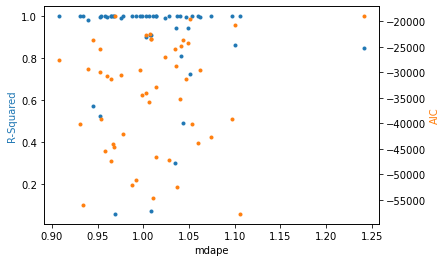

time: 643 ms (started: 2022-08-22 12:08:54 +09:00)


In [35]:
metric = 'mdape'
#metric = 'rmse'
#metric = 'smape'

fig, ax = plt.subplots()

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
c1, c2 = colors[0], colors[1]

ax.scatter(df_pm[metric], df_pm['trend rsquared'], c=c1, label='R-Squared', marker='.')
axt = ax.twinx()
axt.scatter(df_pm[metric], df_pm['trend aic'], c=c2, label='AIC', marker='.')
#ax.legend(loc=1)
#axt.legend(loc=4)
ax.set_xlabel(metric)
ax.set_ylabel('R-Squared')
axt.set_ylabel('AIC')
axt.yaxis.label.set_color(c2)
ax.yaxis.label.set_color(c1)
plt.show()

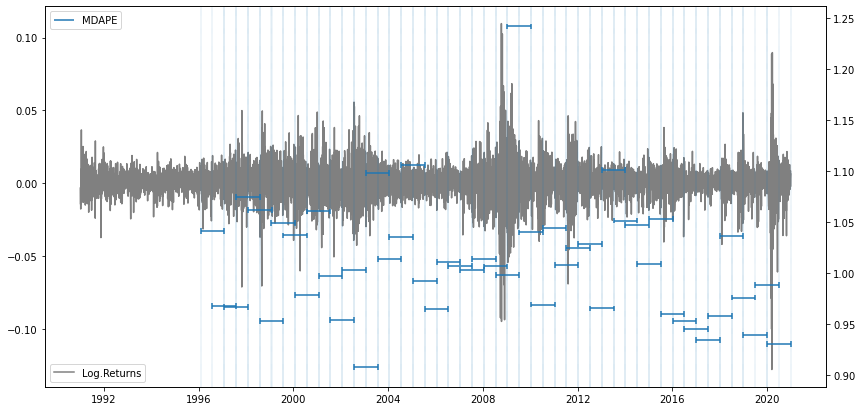

time: 1.58 s (started: 2022-08-22 12:09:58 +09:00)


In [38]:
# result of data to 2020, 5 year init
plot_cv_metric(df_train, df_pm, metric=metric, label='Log.Returns')

### 5. Scheme 3 with Log Transform

In [8]:
df_log = df_snp.copy()
df_log['y'] = df_log['y'].apply(lambda x: np.log(x))
df_log = df_log.dropna(subset='y')
df_log

,ds,y
0,1991-01-02,5.788124
1,1991-01-03,5.774241
2,1991-01-04,5.771441
3,1991-01-07,5.753842
4,1991-01-08,5.752255
...,...,...
7554,2020-12-24,8.216915
7555,2020-12-28,8.225599
7556,2020-12-29,8.223370
7557,2020-12-30,8.224710


time: 67.5 ms (started: 2022-08-22 22:41:29 +09:00)


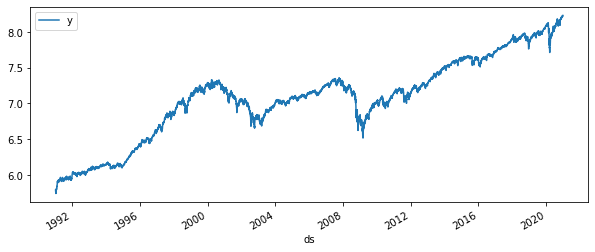

time: 550 ms (started: 2022-08-22 22:41:51 +09:00)


In [10]:
fig, ax = plt.subplots(figsize=(10,4))
_ = df_log.set_index('ds').plot(ax=ax)

In [11]:
hori = YEAR
peri = hori//2
init = 5*YEAR

time: 1.02 ms (started: 2022-08-22 22:42:07 +09:00)


In [22]:
#df_train = df_log.loc[df_log.ds <= '1997-12-31'] # testing
df_train = df_log

time: 896 µs (started: 2022-08-22 22:47:24 +09:00)


In [23]:
model = Prophet()
model.fit(df_train)
df_cv = cross_validation(model, initial=f'{init} days', period=f'{peri} days', horizon = f'{hori} days')

22:47:25 - cmdstanpy - INFO - Chain [1] start processing
22:47:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/49 [00:00<?, ?it/s]

22:47:49 - cmdstanpy - INFO - Chain [1] start processing
22:47:52 - cmdstanpy - INFO - Chain [1] done processing
22:47:58 - cmdstanpy - INFO - Chain [1] start processing
22:48:01 - cmdstanpy - INFO - Chain [1] done processing
22:48:07 - cmdstanpy - INFO - Chain [1] start processing
22:48:11 - cmdstanpy - INFO - Chain [1] done processing
22:48:17 - cmdstanpy - INFO - Chain [1] start processing
22:48:21 - cmdstanpy - INFO - Chain [1] done processing
22:48:27 - cmdstanpy - INFO - Chain [1] start processing
22:48:31 - cmdstanpy - INFO - Chain [1] done processing
22:48:36 - cmdstanpy - INFO - Chain [1] start processing
22:48:41 - cmdstanpy - INFO - Chain [1] done processing
22:48:47 - cmdstanpy - INFO - Chain [1] start processing
22:48:51 - cmdstanpy - INFO - Chain [1] done processing
22:48:57 - cmdstanpy - INFO - Chain [1] start processing
22:49:03 - cmdstanpy - INFO - Chain [1] done processing
22:49:09 - cmdstanpy - INFO - Chain [1] start processing
22:49:15 - cmdstanpy - INFO - Chain [1]

time: 13min 35s (started: 2022-08-22 22:47:25 +09:00)


In [24]:
df_pm = pd.DataFrame()
N = df_cv.cutoff.nunique()
for n, i in enumerate(df_cv.cutoff.unique()):
    ### performace for every cutoff
    df_p = performance_metrics(df_cv.loc[df_cv.cutoff==i])
    # take metric for full test range (one year)
    df_p_l = df_p.iloc[-1:].assign(cutoff=i)
    
    ### trend for each cutoff
    s = df_p_l.iloc[0]
    train = df_train.loc[(df_train.ds < s.cutoff) & (df_train.ds >= s.cutoff - timedelta(days=init))]
    test = df_train.loc[(df_train.ds >= s.cutoff) & (df_train.ds < s.cutoff + s.horizon)]
    m = Prophet().fit(train)
    df_future = pd.concat([train.ds, test.ds]).to_frame()
    df_pred = m.predict(df_future)
    
    y = df_pred.trend
    x = df_pred.ds
    X = sm.add_constant(x.apply(pd.Timestamp.to_julian_date))
    res = sm.OLS(y, X).fit()
    
    df_p_l['trend rsquared'] = res.rsquared
    df_p_l['trend aic'] = res.aic
    #plot_ols_fit(res, x, y)
    
    df_pm = pd.concat([df_pm, df_p_l], ignore_index=True)
    print(f'{(n+1)/N*100:.0f}% finished.')

23:01:03 - cmdstanpy - INFO - Chain [1] start processing
23:01:08 - cmdstanpy - INFO - Chain [1] done processing


2% finished.


23:01:17 - cmdstanpy - INFO - Chain [1] start processing
23:01:20 - cmdstanpy - INFO - Chain [1] done processing


4% finished.


23:01:29 - cmdstanpy - INFO - Chain [1] start processing
23:01:32 - cmdstanpy - INFO - Chain [1] done processing


6% finished.


23:01:42 - cmdstanpy - INFO - Chain [1] start processing
23:01:44 - cmdstanpy - INFO - Chain [1] done processing


8% finished.


23:01:54 - cmdstanpy - INFO - Chain [1] start processing
23:01:58 - cmdstanpy - INFO - Chain [1] done processing


10% finished.


23:02:07 - cmdstanpy - INFO - Chain [1] start processing
23:02:10 - cmdstanpy - INFO - Chain [1] done processing


12% finished.


23:02:20 - cmdstanpy - INFO - Chain [1] start processing
23:02:23 - cmdstanpy - INFO - Chain [1] done processing


14% finished.


23:02:33 - cmdstanpy - INFO - Chain [1] start processing
23:02:37 - cmdstanpy - INFO - Chain [1] done processing


16% finished.


23:02:46 - cmdstanpy - INFO - Chain [1] start processing
23:02:49 - cmdstanpy - INFO - Chain [1] done processing


18% finished.


23:02:58 - cmdstanpy - INFO - Chain [1] start processing
23:03:01 - cmdstanpy - INFO - Chain [1] done processing


20% finished.


23:03:11 - cmdstanpy - INFO - Chain [1] start processing
23:03:14 - cmdstanpy - INFO - Chain [1] done processing


22% finished.


23:03:23 - cmdstanpy - INFO - Chain [1] start processing
23:03:26 - cmdstanpy - INFO - Chain [1] done processing


24% finished.


23:03:35 - cmdstanpy - INFO - Chain [1] start processing
23:03:38 - cmdstanpy - INFO - Chain [1] done processing


27% finished.


23:03:47 - cmdstanpy - INFO - Chain [1] start processing
23:03:50 - cmdstanpy - INFO - Chain [1] done processing


29% finished.


23:04:00 - cmdstanpy - INFO - Chain [1] start processing
23:04:04 - cmdstanpy - INFO - Chain [1] done processing


31% finished.


23:04:13 - cmdstanpy - INFO - Chain [1] start processing
23:04:16 - cmdstanpy - INFO - Chain [1] done processing


33% finished.


23:04:25 - cmdstanpy - INFO - Chain [1] start processing
23:04:29 - cmdstanpy - INFO - Chain [1] done processing


35% finished.


23:04:45 - cmdstanpy - INFO - Chain [1] start processing
23:04:47 - cmdstanpy - INFO - Chain [1] done processing


37% finished.


23:04:56 - cmdstanpy - INFO - Chain [1] start processing
23:05:00 - cmdstanpy - INFO - Chain [1] done processing


39% finished.


23:05:10 - cmdstanpy - INFO - Chain [1] start processing
23:05:12 - cmdstanpy - INFO - Chain [1] done processing


41% finished.


23:05:21 - cmdstanpy - INFO - Chain [1] start processing
23:05:26 - cmdstanpy - INFO - Chain [1] done processing


43% finished.


23:05:36 - cmdstanpy - INFO - Chain [1] start processing
23:05:38 - cmdstanpy - INFO - Chain [1] done processing


45% finished.


23:05:48 - cmdstanpy - INFO - Chain [1] start processing
23:05:50 - cmdstanpy - INFO - Chain [1] done processing


47% finished.


23:05:59 - cmdstanpy - INFO - Chain [1] start processing
23:06:02 - cmdstanpy - INFO - Chain [1] done processing


49% finished.


23:06:11 - cmdstanpy - INFO - Chain [1] start processing
23:06:14 - cmdstanpy - INFO - Chain [1] done processing


51% finished.


23:06:23 - cmdstanpy - INFO - Chain [1] start processing
23:06:27 - cmdstanpy - INFO - Chain [1] done processing


53% finished.


23:06:36 - cmdstanpy - INFO - Chain [1] start processing
23:06:40 - cmdstanpy - INFO - Chain [1] done processing


55% finished.


23:06:49 - cmdstanpy - INFO - Chain [1] start processing
23:06:52 - cmdstanpy - INFO - Chain [1] done processing


57% finished.


23:07:01 - cmdstanpy - INFO - Chain [1] start processing
23:07:06 - cmdstanpy - INFO - Chain [1] done processing


59% finished.


23:07:16 - cmdstanpy - INFO - Chain [1] start processing
23:07:20 - cmdstanpy - INFO - Chain [1] done processing


61% finished.


23:07:29 - cmdstanpy - INFO - Chain [1] start processing
23:07:32 - cmdstanpy - INFO - Chain [1] done processing


63% finished.


23:07:41 - cmdstanpy - INFO - Chain [1] start processing
23:07:44 - cmdstanpy - INFO - Chain [1] done processing


65% finished.


23:07:54 - cmdstanpy - INFO - Chain [1] start processing
23:07:56 - cmdstanpy - INFO - Chain [1] done processing


67% finished.


23:08:05 - cmdstanpy - INFO - Chain [1] start processing
23:08:08 - cmdstanpy - INFO - Chain [1] done processing


69% finished.


23:08:17 - cmdstanpy - INFO - Chain [1] start processing
23:08:22 - cmdstanpy - INFO - Chain [1] done processing


71% finished.


23:08:31 - cmdstanpy - INFO - Chain [1] start processing
23:08:35 - cmdstanpy - INFO - Chain [1] done processing


73% finished.


23:08:44 - cmdstanpy - INFO - Chain [1] start processing
23:08:49 - cmdstanpy - INFO - Chain [1] done processing


76% finished.


23:08:58 - cmdstanpy - INFO - Chain [1] start processing
23:09:01 - cmdstanpy - INFO - Chain [1] done processing


78% finished.


23:09:11 - cmdstanpy - INFO - Chain [1] start processing
23:09:14 - cmdstanpy - INFO - Chain [1] done processing


80% finished.


23:09:24 - cmdstanpy - INFO - Chain [1] start processing
23:09:26 - cmdstanpy - INFO - Chain [1] done processing


82% finished.


23:09:36 - cmdstanpy - INFO - Chain [1] start processing
23:09:38 - cmdstanpy - INFO - Chain [1] done processing


84% finished.


23:09:47 - cmdstanpy - INFO - Chain [1] start processing
23:09:50 - cmdstanpy - INFO - Chain [1] done processing


86% finished.


23:09:59 - cmdstanpy - INFO - Chain [1] start processing
23:10:02 - cmdstanpy - INFO - Chain [1] done processing


88% finished.


23:10:11 - cmdstanpy - INFO - Chain [1] start processing
23:10:14 - cmdstanpy - INFO - Chain [1] done processing


90% finished.


23:10:23 - cmdstanpy - INFO - Chain [1] start processing
23:10:26 - cmdstanpy - INFO - Chain [1] done processing


92% finished.


23:10:35 - cmdstanpy - INFO - Chain [1] start processing
23:10:38 - cmdstanpy - INFO - Chain [1] done processing


94% finished.


23:10:47 - cmdstanpy - INFO - Chain [1] start processing
23:10:51 - cmdstanpy - INFO - Chain [1] done processing


96% finished.


23:11:00 - cmdstanpy - INFO - Chain [1] start processing
23:11:03 - cmdstanpy - INFO - Chain [1] done processing


98% finished.


23:11:12 - cmdstanpy - INFO - Chain [1] start processing
23:11:16 - cmdstanpy - INFO - Chain [1] done processing


100% finished.
time: 10min 22s (started: 2022-08-22 23:01:00 +09:00)


In [25]:
df_pm.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage,cutoff,trend rsquared,trend aic
0,365 days,0.008338,0.091311,0.090310,0.013611,0.013575,0.013517,1.0,1996-01-31,0.862000,-3297.754278
1,365 days,0.023565,0.153509,0.152453,0.022330,0.022231,0.022586,1.0,1996-07-31,0.908833,-4047.432782
2,365 days,0.001283,0.035823,0.033231,0.004836,0.004665,0.004850,1.0,1997-01-29,0.911893,-3516.833657
3,365 days,0.001274,0.035698,0.032306,0.004577,0.004972,0.004590,1.0,1997-07-30,0.895574,-2355.853789
4,365 days,0.006370,0.079815,0.078472,0.011019,0.011025,0.010956,1.0,1998-01-28,0.940745,-3280.626600


time: 62.9 ms (started: 2022-08-22 23:11:23 +09:00)


R-squared vs metric plot shows more equally distributed scatters than that of not-transformed

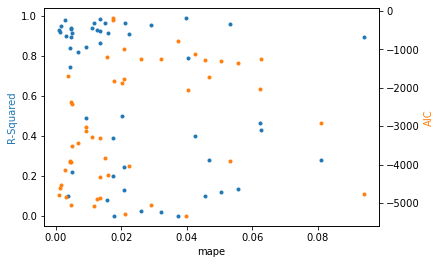

time: 611 ms (started: 2022-08-22 23:11:23 +09:00)


In [26]:
metric = 'mape'
#metric = 'rmse'
#metric = 'smape'

fig, ax = plt.subplots()

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
c1, c2 = colors[0], colors[1]

ax.scatter(df_pm[metric], df_pm['trend rsquared'], c=c1, label='R-Squared', marker='.')
axt = ax.twinx()
axt.scatter(df_pm[metric], df_pm['trend aic'], c=c2, label='AIC', marker='.')
#ax.legend(loc=1)
#axt.legend(loc=4)
ax.set_xlabel(metric)
ax.set_ylabel('R-Squared')
axt.set_ylabel('AIC')
axt.yaxis.label.set_color(c2)
ax.yaxis.label.set_color(c1)
plt.show()

Similarly metric looks like more equally distributed than that of not-transformed

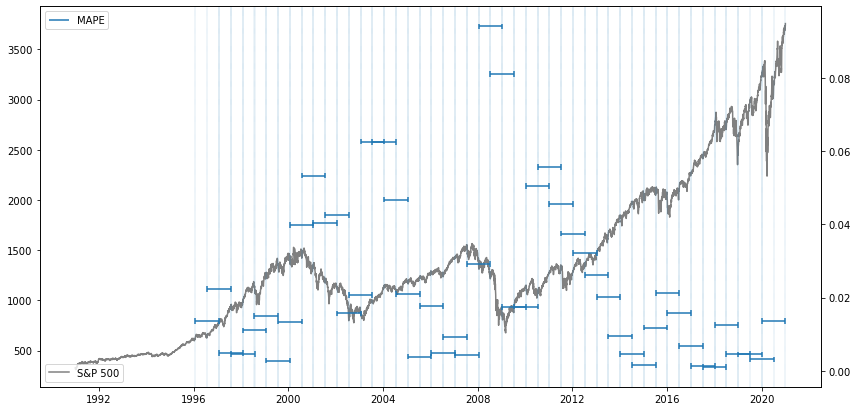

time: 1.6 s (started: 2022-08-22 23:11:23 +09:00)


In [27]:
# result of data to 2020, 5 year init
df = df_train.assign(y=np.exp(df_train.y))
plot_cv_metric(df, df_pm, metric=metric, label='S&P 500')